In [2]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql as pms
import json
import time


from sqlalchemy import create_engine
import getpass
import keyring
from sqlalchemy import create_engine, text

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

import plotly.express as px

#import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import keyring
from sqlalchemy import create_engine, text
import trino
from gspread_pandas import Spread, Client
import json


In [12]:
starburst_config = {
    'user': 'mingyi.zeng@glovoapp.com',
    'host': 'starburst.g8s-data-platform-prod.glovoint.com',
    'port': 443,
    'http_scheme': 'https'
} 

def starburst(func):
    '''
    Wrapper for functions executing a query against Starburst.
    '''
    def con(*args, **kwargs):
        try:
            conn = trino.dbapi.connect(auth=trino.auth.OAuth2Authentication(), **starburst_config)
            value = func(conn, *args, **kwargs)
        except Exception as e:
            raise e
        finally:
            conn.close()
        return value
    return con

@starburst
def get_starburst_data_from_sql(con, sql_query:str) -> pd.DataFrame:
    '''
    Execute the query in sql_query string on Starburst and return the resulting pd.DataFrame.
    
    Arguments:
    - con: left empty as it will be passed inside dwh wrapper.
    - sql_query: a string representing the SQL query to be executed.

    Returns:
    - data: a pd.DataFrame with the results from sql_query.
    '''
    data = pd.read_sql(sql=sql_query, con=con)
    return data

In [13]:
sql_star='''

   SELECT 
    
    date_trunc('day', rfs.p_creation_date) AS day_creation,
    rfs.ml_uch_score AS ml_score,
    CASE WHEN p.payment_status = 'NOT_PAID' THEN 1 ELSE 0 END AS unpaid,
    o.order_total_purchase_eur AS gtv_eur,
    o.order_id,
    fm.cm0_eur AS cm0_eur
    
    FROM
    
        "sensitive_delta"."central_risk_engine_odp"."risk_feature_snapshots_enhanced" rfs

    INNER JOIN (SELECT customer_id
                     FROM legacy_dwh.public.risk_user_hashing
                     WHERE CAST(hash_crc32 AS real) < (0.04 * CAST(4294967295 AS real))
                     ) AS cg ON cg.customer_id = rfs.customer_id
                     
    LEFT JOIN  "sensitive_delta"."central_checkout_orders_odp"."checkout_orders" co ON rfs.checkout_id = co.checkout_id
    LEFT JOIN "sensitive_delta"."central_risk_engine_odp"."risk_decisions" rd ON rd.decision_id = rfs.decision_id
    LEFT JOIN  "delta"."central_order_descriptors_odp"."order_descriptors_v2" o ON co.order_id = o.order_id
    LEFT JOIN "delta"."fintech_payments_odp"."payments" p ON p.order_id = o.order_id
    LEFT JOIN delta.finance_financial_metrics_odp.financial_order_metrics fm ON fm.order_id = p.order_id



    
    WHERE 
        rfs.checkpoint = 'checkout'
        AND p.payment_method = 'CASH'
        AND o.order_country_code = 'MA'
        AND p.bundled_payment_parent_id IS NULL
        AND rfs.p_creation_date > current_date  - interval '30' day 
        AND o.order_final_status IN ('CanceledStatus', 'DeliveredStatus')
        AND customer_finished_orders_count > 0 --Existent Customers
        --and rd.rule = 'ml_cash_unpaid_cg' --called when rules get called
        
    ORDER BY 1 DESC

'''

In [14]:
%%time
data = get_starburst_data_from_sql(sql_star)

CPU times: user 1.39 s, sys: 333 ms, total: 1.73 s
Wall time: 2min 4s


In [15]:
df = data.copy()

In [16]:
df

,day_creation,ml_score,unpaid,gtv_eur,order_id,cm0_eur
0,2023-07-17,0.0,0,15.158192,659961213,4.177037
1,2023-07-17,0.0,0,5.309989,660234447,0.673535
2,2023-07-17,0.0,0,4.806256,659858052,0.778060
3,2023-07-17,0.0,0,8.041236,660091116,0.747696
4,2023-07-17,0.0,0,5.268396,660221979,0.376515
...,...,...,...,...,...,...
58455,2023-06-19,0.0,0,16.715062,642339689,2.327418
58456,2023-06-19,0.0,0,8.233020,642575643,-0.264130
58457,2023-06-19,7.0,0,7.255439,642539499,0.938744
58458,2023-06-19,0.0,0,6.337029,642182592,1.177328


In [17]:
df = df.sort_values(by=['ml_score'])
df['ml_score'] = df['ml_score'].astype(float)
df['gtv_eur'] = df['gtv_eur'].astype(float)
df=df.dropna(axis=0)
df

,day_creation,ml_score,unpaid,gtv_eur,order_id,cm0_eur
0,2023-07-17,0.0,0,15.158192,659961213,4.177037
37702,2023-07-06,0.0,0,26.693160,653094540,4.887035
37703,2023-07-06,0.0,0,14.192490,652935903,1.026800
37704,2023-07-06,0.0,0,9.117030,652896906,1.461153
37705,2023-07-06,0.0,0,8.741070,652668966,1.129641
...,...,...,...,...,...,...
33203,2023-07-07,99.0,0,0.000000,653822757,0.000000
13794,2023-07-13,99.0,0,0.000000,657408796,1.928225
33213,2023-07-07,99.0,0,0.000000,653822757,0.000000
51333,2023-06-25,99.0,0,0.000000,646357290,0.000000


In [18]:
precision, recall, thresholds = precision_recall_curve(df['unpaid'].astype(float), df['ml_score'].astype(float))


(0.0, 1.0)

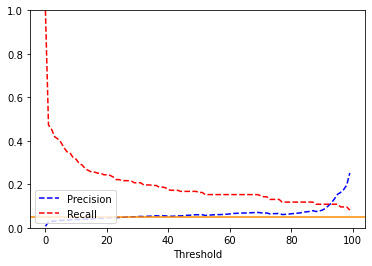

In [19]:
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.axhline(y=0.05, color='darkorange', linestyle='-')

plt.ylim([0,1])

In [20]:
def calculate_net_savings(data):
    thresholds = range(101)  # Generate thresholds from 0 to 100
    net_savings = []
    block_rates = []
    money_lost = []
    money_gained = []
    false_positives = []


    for threshold in thresholds:
        # Filter data based on the threshold
        filtered_data = df[df['ml_score'] >= threshold]

        # Calculate true positives (TP) and false positives (FP)
        tp = filtered_data[(filtered_data['unpaid'] == 1) & (filtered_data['gtv_eur'] > 0)]
        fp = filtered_data[(filtered_data['unpaid'] == 0) & (filtered_data['gtv_eur'] > 0)]
        
        false_positives.append(len(fp))
        
        
        #filter data on threshold
        filtered_data_fn = df[df['ml_score'] < threshold]

        tn = filtered_data_fn[(filtered_data_fn['unpaid'] == 0) & (filtered_data_fn['gtv_eur'] > 0)]
        fn = filtered_data_fn[(filtered_data_fn['unpaid'] == 1) & (filtered_data_fn['gtv_eur'] > 0)]


        # Calculate net savings from blocks 
        net_saving = tp['gtv_eur'].sum() - fp['cm0_eur'].sum()
        net_savings.append(net_saving)
        
        # Calculate block rate
        block_rate = len(filtered_data)/ len(df)
        block_rates.append(block_rate)
        
        # Calculate money lost due to FN 
        money_losts = fn['gtv_eur'].sum()
        money_lost.append(money_losts)

        # Calculate money (profit) gained due to TN 
        money_in = tn['cm0_eur'].sum()
        money_gained.append(money_in)

        
        

    # Create a DataFrame with thresholds, net savings, and block rates
    results = pd.DataFrame({'Threshold': thresholds, 'Net Savings': net_savings, 'Block Rate': block_rates,
                           'money_lost': money_lost, 'money_gained': money_gained,
                           'false_positives': false_positives})

    return results

# Example usage
# Assuming your DataFrame is called "df"
threshold_net_savings = calculate_net_savings(df)
print(threshold_net_savings)

     Threshold   Net Savings  Block Rate   money_lost  money_gained  \
0            0 -71977.009722    1.000000     0.000000      0.000000   
1            1  -6593.572612    0.121921  2708.651462  68092.088571   
2            2  -5564.772205    0.106698  2830.245540  69242.483057   
3            3  -4983.795113    0.095612  2966.617093  69959.831702   
4            4  -4476.152958    0.087510  2996.731483  70497.588247   
..         ...           ...         ...          ...           ...   
96          96   -121.883464    0.004138  3964.400015  75819.526273   
97          97   -121.883464    0.003827  3964.400015  75819.526273   
98          98    -96.506289    0.003431  3964.400015  75844.903447   
99          99    -47.245419    0.002258  3964.400015  75894.164318   
100        100      0.000000    0.000000  3964.400015  75941.409737   

     false_positives  
0              55794  
1               6247  
2               5394  
3               4782  
4               4341  
..       

In [21]:
threshold_net_savings['net'] = threshold_net_savings['money_gained'] - threshold_net_savings['money_lost']
threshold_net_savings['total'] = threshold_net_savings['net'] + threshold_net_savings['Net Savings']

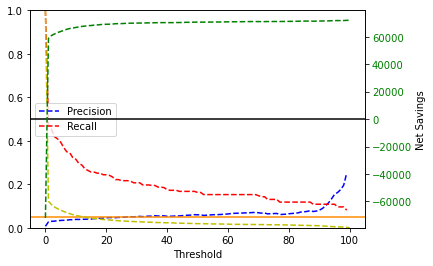

In [22]:
precision, recall, thresholds = precision_recall_curve(df['unpaid'].astype(float), df['ml_score'].astype(float))


plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.axhline(y=0.05, color='darkorange', linestyle='-') #break even precision
plt.plot(threshold_net_savings['Threshold'], threshold_net_savings['Block Rate'], 'y--', label='Recall')


plt.ylim([0,1])

# Plot savings on right-hand axis
ax2 = plt.twinx()
plt.axhline(y=0, color='black', linestyle='-')

ax2.plot(threshold_net_savings['Threshold'], threshold_net_savings['total'], 'g--', label='Savings')
ax2.set_ylabel('Net Savings')
ax2.tick_params(axis='y', labelcolor='g')

plt.show()

In [22]:
threshold_net_savings['total']

0     -55964.186610
1      46206.756126
2      48797.223089
3      50127.503784
4      51191.307959
5      52034.432875
6      52547.590954
7      53277.768767
8      53864.605751
9      54207.317595
10     54542.264310
11     54777.166266
12     54894.883756
13     55063.005413
14     55250.042520
15     55371.605915
16     55567.879431
17     55714.745616
18     55822.551170
19     56040.335479
20     56221.888666
21     56392.237190
22     56496.586380
23     56618.827843
24     56711.103607
25     56800.608836
26     56628.849257
27     56692.128162
28     56741.773380
29     56765.082913
30     56846.422439
31     56952.904941
32     57063.902662
33     57112.504459
34     57151.478123
35     57252.037946
36     57409.826002
37     57515.859897
38     57531.965064
39     57601.383743
40     57701.695815
41     57680.245670
42     57689.408631
43     57824.927425
44     57924.361972
45     57908.981428
46     57993.304549
47     58000.853205
48     58013.903382
49     58050.834621


In [3]:
pd.set_option('display.max_rows', 200)


In [33]:
threshold_net_savings
threshold_net_savings.to_csv('/Users/mingyi.zeng/Downloads/out.csv') 

In [29]:
pd.reset_option('display.max_rows')